In [155]:
# Libraries and Dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import time
import os
import yfinance as yf
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
%matplotlib inline

# Inputs

In [2]:
load_dotenv()

True

In [3]:
# Set the start and end dates
start_date = "2019-04-01"
end_date = "2023-07-03"

# Retrieve the Ethereum data
BTC = yf.Ticker("BTC-USD")
BTC_data = BTC.history(start = start_date, end = end_date)

# Display the DataFrame with hourly data for Ethereum
df_stock = pd.DataFrame(BTC_data)
df_stock.index = pd.to_datetime(df_stock.index, infer_datetime_format=True)
df_stock.index.name = 'date'
df_stock.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
date,,,,,,,
2023-06-28 00:00:00+00:00,30696.560547,30703.279297,29921.822266,30086.246094,14571500779,0.0,0.0
2023-06-29 00:00:00+00:00,30086.187500,30796.250000,30057.203125,30445.351562,13180860821,0.0,0.0
2023-06-30 00:00:00+00:00,30441.353516,31256.863281,29600.275391,30477.251953,26387306197,0.0,0.0
2023-07-01 00:00:00+00:00,30471.847656,30641.289062,30328.865234,30590.078125,9086606733,0.0,0.0
2023-07-02 00:00:00+00:00,30587.269531,30766.140625,30264.019531,30620.769531,10533418042,0.0,0.0


In [4]:
df_data = df_stock.copy()

In [5]:
df_close = df_data['Close']
df_profolio = pd.DataFrame(df_close)
df_profolio.head()

,Close
date,
2019-04-01 00:00:00+00:00,4158.183105
2019-04-02 00:00:00+00:00,4879.877930
2019-04-03 00:00:00+00:00,4973.021973
2019-04-04 00:00:00+00:00,4922.798828
2019-04-05 00:00:00+00:00,5036.681152


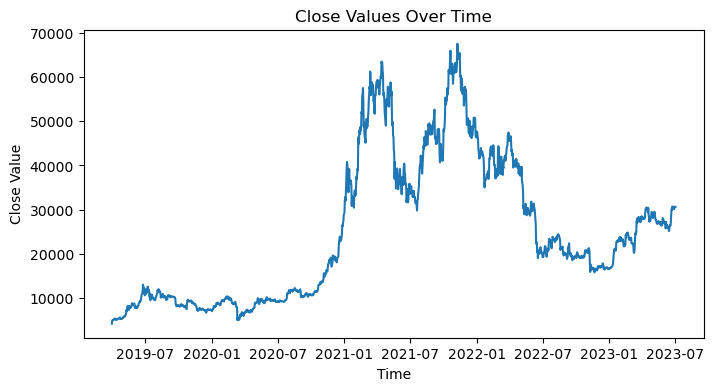

In [7]:
from matplotlib import pyplot as plt
# Create the plot
plt.figure(figsize=(8, 4)) # you can adjust the size as needed
plt.plot(df_profolio["Close"])

# Add title and labels if needed
plt.title("Close Values Over Time")
plt.xlabel("Time")
plt.ylabel("Close Value")

# Save the plot
plt.savefig('./Images/stock.png')

----------------------------------------------

# Data Processing

In [8]:
df_stock_copy = df_stock.copy()

In [9]:
df_stock_copy["actual_returns"] = df_stock_copy["Close"].pct_change()
df_stock_copy.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns
date,,,,,,,,
2019-04-01 00:00:00+00:00,4105.362305,4164.953125,4096.901367,4158.183105,10157794171,0.0,0.0,NaN
2019-04-02 00:00:00+00:00,4156.919434,4905.954590,4155.316895,4879.877930,21315047816,0.0,0.0,0.173560
2019-04-03 00:00:00+00:00,4879.958008,5307.003418,4876.621094,4973.021973,22899891582,0.0,0.0,0.019087
2019-04-04 00:00:00+00:00,4971.307617,5063.159668,4836.793945,4922.798828,18251810240,0.0,0.0,-0.010099
2019-04-05 00:00:00+00:00,4922.806152,5053.509766,4919.491699,5036.681152,16837325387,0.0,0.0,0.023134


In [10]:
df_ml = df_stock_copy.dropna()
display(df_ml.head())
display(df_ml.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns
date,,,,,,,,
2019-04-02 00:00:00+00:00,4156.919434,4905.954590,4155.316895,4879.877930,21315047816,0.0,0.0,0.173560
2019-04-03 00:00:00+00:00,4879.958008,5307.003418,4876.621094,4973.021973,22899891582,0.0,0.0,0.019087
2019-04-04 00:00:00+00:00,4971.307617,5063.159668,4836.793945,4922.798828,18251810240,0.0,0.0,-0.010099
2019-04-05 00:00:00+00:00,4922.806152,5053.509766,4919.491699,5036.681152,16837325387,0.0,0.0,0.023134
2019-04-06 00:00:00+00:00,5036.792969,5205.821777,4992.222168,5059.817383,16929795194,0.0,0.0,0.004594


,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns
date,,,,,,,,
2023-06-28 00:00:00+00:00,30696.560547,30703.279297,29921.822266,30086.246094,14571500779,0.0,0.0,-0.019614
2023-06-29 00:00:00+00:00,30086.187500,30796.250000,30057.203125,30445.351562,13180860821,0.0,0.0,0.011936
2023-06-30 00:00:00+00:00,30441.353516,31256.863281,29600.275391,30477.251953,26387306197,0.0,0.0,0.001048
2023-07-01 00:00:00+00:00,30471.847656,30641.289062,30328.865234,30590.078125,9086606733,0.0,0.0,0.003702
2023-07-02 00:00:00+00:00,30587.269531,30766.140625,30264.019531,30620.769531,10533418042,0.0,0.0,0.001003


In [11]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
df_ml["sma_fast"] = df_ml["Close"].rolling(window=short_window).mean()

# Define a window size of 20
long_window = 20

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
df_ml["sma_slow"] = df_ml["Close"].rolling(window=long_window).mean()

trading_df = df_ml.dropna()

X = trading_df[["sma_fast", "sma_slow"]].shift().dropna().copy()

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [12]:
X.head()

,sma_fast,sma_slow
date,,
2019-04-22 00:00:00+00:00,5313.653931,5155.896631
2019-04-23 00:00:00+00:00,5338.898804,5181.870996
2019-04-24 00:00:00+00:00,5406.036255,5211.838013
2019-04-25 00:00:00+00:00,5437.781372,5238.941406
2019-04-26 00:00:00+00:00,5411.777466,5247.633130


In [13]:
trading_df["signal"] = 0.0
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1
y = trading_df["signal"].copy()
y[10:]

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


date
2019-05-01 00:00:00+00:00    1.0
2019-05-02 00:00:00+00:00    1.0
2019-05-03 00:00:00+00:00    1.0
2019-05-04 00:00:00+00:00    1.0
2019-05-05 00:00:00+00:00   -1.0
                            ... 
2023-06-28 00:00:00+00:00   -1.0
2023-06-29 00:00:00+00:00    1.0
2023-06-30 00:00:00+00:00    1.0
2023-07-01 00:00:00+00:00    1.0
2023-07-02 00:00:00+00:00    1.0
Name: signal, Length: 1524, dtype: float64

In [14]:
from pandas.tseries.offsets import DateOffset
begin = X.index.min()
end = X.index.min() + DateOffset(months=24)

In [15]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[begin:end]
y_train = y.loc[begin:end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[end:]
y_test = y.loc[end:]

In [16]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

-----------------------

# Machine Learning Analysis

## Prophet

In [19]:
df = df_profolio.reset_index()
df.columns = ["ds", "y"]
display(df.shape)
display(df.head())
display(df.tail())

(1554, 2)

,ds,y
0,2019-04-01 00:00:00+00:00,4158.183105
1,2019-04-02 00:00:00+00:00,4879.877930
2,2019-04-03 00:00:00+00:00,4973.021973
3,2019-04-04 00:00:00+00:00,4922.798828
4,2019-04-05 00:00:00+00:00,5036.681152


,ds,y
1549,2023-06-28 00:00:00+00:00,30086.246094
1550,2023-06-29 00:00:00+00:00,30445.351562
1551,2023-06-30 00:00:00+00:00,30477.251953
1552,2023-07-01 00:00:00+00:00,30590.078125
1553,2023-07-02 00:00:00+00:00,30620.769531


In [20]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [21]:
df = df.sort_values(by=["ds"], ascending=True)
# Display sample data from head and tail
display(df.head(10))
display(df.tail(10))

,ds,y
0,2019-04-01,4158.183105
1,2019-04-02,4879.877930
2,2019-04-03,4973.021973
3,2019-04-04,4922.798828
4,2019-04-05,5036.681152
5,2019-04-06,5059.817383
6,2019-04-07,5198.896973
7,2019-04-08,5289.770996
8,2019-04-09,5204.958496
9,2019-04-10,5324.551758


,ds,y
1544,2023-06-23,30695.468750
1545,2023-06-24,30548.695312
1546,2023-06-25,30480.261719
1547,2023-06-26,30271.130859
1548,2023-06-27,30688.164062
1549,2023-06-28,30086.246094
1550,2023-06-29,30445.351562
1551,2023-06-30,30477.251953
1552,2023-07-01,30590.078125
1553,2023-07-02,30620.769531


In [22]:
# Call the Prophet function, store as an object
pr_model = Prophet()

# Fit the Prophet model.
pr_model.fit(df)

17:36:11 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 1000 hours (approx 40 days)
pr_future_trends = pr_model.make_future_dataframe(periods=1000, freq="H")

In [24]:
# View the last five rows of the predictions
pr_future_trends.tail()

,ds
2549,2023-08-12 12:00:00
2550,2023-08-12 13:00:00
2551,2023-08-12 14:00:00
2552,2023-08-12 15:00:00
2553,2023-08-12 16:00:00


In [25]:
# Make the predictions for the trend data using the future_trends DataFrame
pr_forecast_trends = pr_model.predict(pr_future_trends)

# Display the first five rows of the forecast DataFrame
pr_forecast_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-01,2031.281824,2878.666820,10131.238245,2031.281824,2031.281824,4529.448568,4529.448568,4529.448568,-4.387027,-4.387027,-4.387027,4533.835596,4533.835596,4533.835596,0.0,0.0,0.0,6560.730392
1,2019-04-02,2116.191530,2782.411596,10492.452520,2116.191530,2116.191530,4531.280386,4531.280386,4531.280386,-11.602680,-11.602680,-11.602680,4542.883066,4542.883066,4542.883066,0.0,0.0,0.0,6647.471916
2,2019-04-03,2201.101236,3068.740018,10625.804111,2201.101236,2201.101236,4584.291203,4584.291203,4584.291203,53.125947,53.125947,53.125947,4531.165256,4531.165256,4531.165256,0.0,0.0,0.0,6785.392439
3,2019-04-04,2286.010941,3084.462822,10322.544049,2286.010941,2286.010941,4457.071122,4457.071122,4457.071122,-43.917540,-43.917540,-43.917540,4500.988662,4500.988662,4500.988662,0.0,0.0,0.0,6743.082064
4,2019-04-05,2370.920647,2725.237892,10628.166142,2370.920647,2370.920647,4444.195586,4444.195586,4444.195586,-10.731128,-10.731128,-10.731128,4454.926714,4454.926714,4454.926714,0.0,0.0,0.0,6815.116234


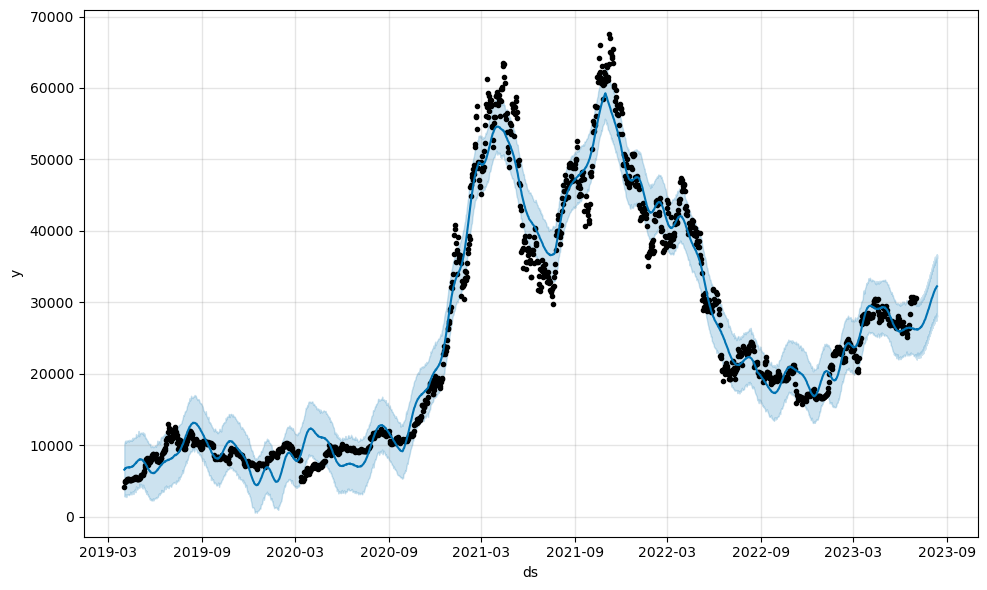

In [26]:
# Plot the Prophet predictions for the Mercado trends data
pr_fig = pr_model.plot(pr_forecast_trends)
# Save the plot
plt.savefig('./Images/prophet.png')
# Display the plot
plt.show()

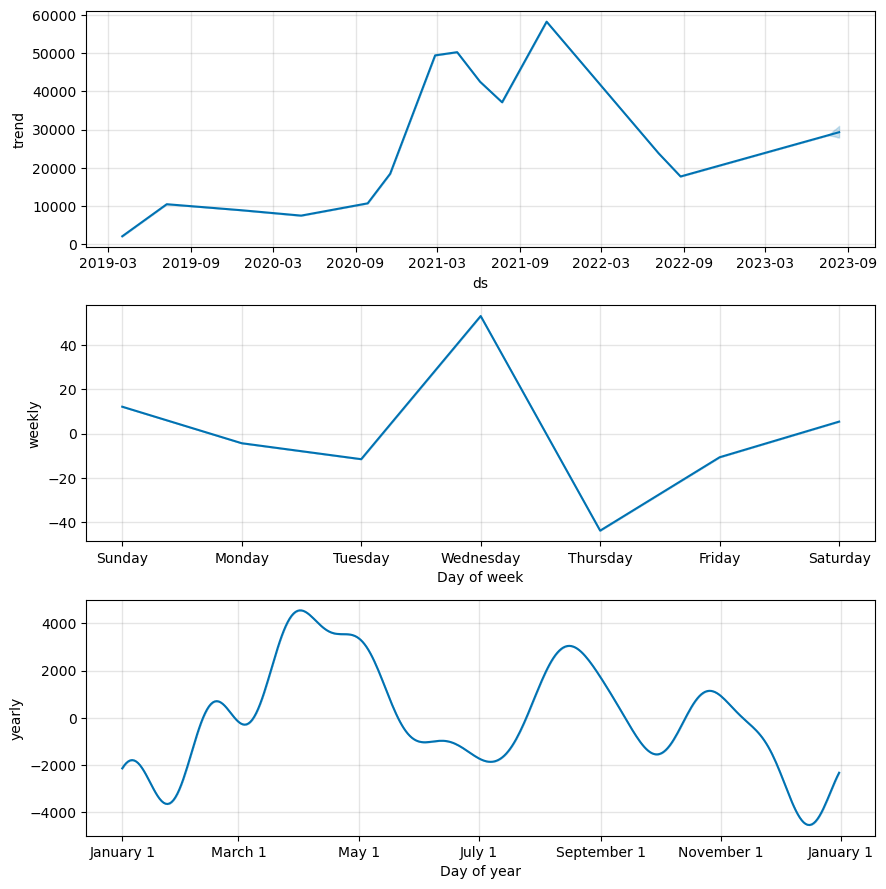

In [27]:
# Use the plot_components function to visualize the forecast results 
pr_figures = pr_model.plot_components(pr_forecast_trends)
# Save the plot
plt.savefig('./Images/prophet_components.png')

In [28]:
# At this point, it's useful to set the `datetime` index of the forecast data.
pr_forecast_trends = pr_forecast_trends.set_index(["ds"])

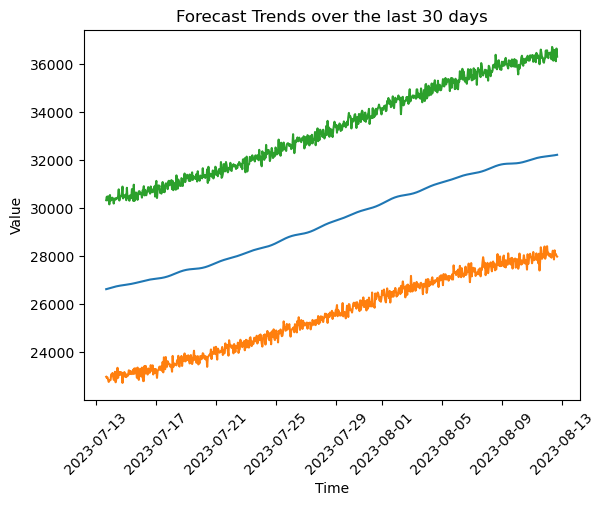

In [29]:
#  the yhat, yhat_lower, and yhat_upper columns over the last 30 days
pr_plot_last30days = plt.plot(pr_forecast_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-720:, :])
plt.title("Forecast Trends over the last 30 days")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation=45)

# Save the plot
plt.savefig('./Images/prophet_predict.png')


In [30]:
# The DataFrame should include the columns yhat_upper, yhat_lower, and yhat
pr_forecast_aug_2023 = pr_forecast_trends.loc["2023-07-13":"2023-08-13"][["yhat_upper", "yhat_lower", "yhat"]]

# Replace the column names to something less technical sounding
pr_forecast_aug_2023 = pr_forecast_aug_2023.rename(
    columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case", 
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
pr_forecast_aug_2023.tail()

,Best Case,Worst Case,Most Likely Case
ds,,,
2023-08-12 12:00:00,36608.703072,28249.672550,32215.271183
2023-08-12 13:00:00,36530.948707,28079.963345,32219.711257
2023-08-12 14:00:00,36135.001407,28090.962354,32224.298853
2023-08-12 15:00:00,36666.382108,28020.749742,32229.025171
2023-08-12 16:00:00,36327.889381,27988.727415,32233.878370


In [31]:
# Display the average forecasted price for March 2021
pr_forecast_aug_2023.mean()

Best Case           33286.809778
Worst Case          25482.463712
Most Likely Case    29372.114637
dtype: float64

-----------------------

## Neural Networks - Tensorflow, Keras

In [69]:
X_df = df_ml[['Open','High','Low','Close','Volume','actual_returns']].reset_index().drop(columns=['date'])
X_nn = X_df[['Open','High','Low','Close','Volume']]

In [172]:
# y_df = df_ml[['actual_returns']].reset_index().drop(columns='date')
# y_nn = y_df['actual_returns']
# y_nn

# Create a new column in the `trading_df` called "signal" setting its value to zero.
X_df["signal"] = 0.0

# Create the signal to buy
X_df.loc[(X_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
X_df.loc[(X_df["actual_returns"] < 0), "signal"] = 0

y_nn = X_df["signal"].copy()

In [57]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, random_state=1)

In [58]:
 # Create the StandardScaler instance
X_scaler_nn = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler_nn.fit(X_train_nn)

# Scale both the training and testing data from the features dataset
X_train_scaled_nn = X_scaler_nn.transform(X_train_nn)
X_test_scaled_nn = X_scaler_nn.transform(X_test_nn)

In [59]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_nn.columns)

In [60]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  12

# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 6

# Create the Sequential model instance
nn = Sequential()


In [61]:
# Add the first hidden layer specifying the number of inputs, the number of hidden nodes, and the activation function
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second hidden layer specifying the number of hidden nodes and the activation function
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=1, activation="sigmoid"))

In [62]:
# Display the Sequential model summary
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                72        
                                                                 
 dense_4 (Dense)             (None, 6)                 78        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [65]:
# Fit the model using 50 epochs and the training data
num_epochs = 100
model_1 = nn.fit(X_train_scaled_nn, y_train_nn, epochs=num_epochs)

Epoch 1/100
37/37 [==============================] - 1s 2ms/step - loss: 0.7413 - accuracy: 0.5232
Epoch 2/100
37/37 [==============================] - 0s 2ms/step - loss: 0.7080 - accuracy: 0.5146
Epoch 3/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.5249
Epoch 4/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5275
Epoch 5/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5215
Epoch 6/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6916 - accuracy: 0.5318
Epoch 7/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6904 - accuracy: 0.5361
Epoch 8/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5421
Epoch 9/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5567
Epoch 10/100
37/37 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.5567
Epoch 11/

In [66]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled_nn, y_test_nn)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

13/13 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.9280
Loss: 0.34608781337738037, Accuracy: 0.9280205368995667


In [67]:
# Set the model's file path
file_path = Path('Resources/nn.h5')

# Export your model to a HDF5 file
nn.save(file_path)

---------------------------------------------------------------------

## Scikit-learn

In [ ]:
# Create a list of categorical variables 
categorical_variables = list(applicant_data_df.dtypes[applicant_data_df.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

---------------------------------------------------------------------

### Logistic Regression Model

In [173]:
X_df.head()

,Open,High,Low,Close,Volume,actual_returns,signal
0,4156.919434,4905.954590,4155.316895,4879.877930,21315047816,0.173560,1.0
1,4879.958008,5307.003418,4876.621094,4973.021973,22899891582,0.019087,1.0
2,4971.307617,5063.159668,4836.793945,4922.798828,18251810240,-0.010099,0.0
3,4922.806152,5053.509766,4919.491699,5036.681152,16837325387,0.023134,1.0
4,5036.792969,5205.821777,4992.222168,5059.817383,16929795194,0.004594,1.0


In [206]:
X_lr = X_nn[['Open','High','Low','Close','Volume']]
y_lr = X_df['signal']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=42)

In [207]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model

logistic_regression_model = LogisticRegression(random_state=1)
lr_model = logistic_regression_model.fit(X_train_lr, y_train_lr)

In [208]:
# Make a prediction using the testing data
lr_predictions = lr_model.predict(X_train_lr)
testing_predictions = logistic_regression_model.predict(X_test_lr)

In [209]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_train_lr, lr_predictions)

0.5197594501718213

In [210]:
# Gen# Create and save the confustion matrix for the training data
training_matrix = confusion_matrix(y_train_lr, lr_predictions)
training_matrix

array([[  0, 559],
       [  0, 605]], dtype=int64)

In [211]:
# Create and save the confustion matrix for the testing data
test_matrix = confusion_matrix(y_test_lr, testing_predictions)
test_matrix

array([[  0, 198],
       [  0, 191]], dtype=int64)

In [212]:
 # Create and save the training classifiction report
report_lr = classification_report(y_train_lr, lr_predictions)

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [213]:
testing_report_lr = classification_report(y_test_lr, testing_predictions)
print(testing_report_lr)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       198
         1.0       0.49      1.00      0.66       191

    accuracy                           0.49       389
   macro avg       0.25      0.50      0.33       389
weighted avg       0.24      0.49      0.32       389



C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\boris\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------------------------------------------------

### Algo trading

In [109]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["Close"].pct_change()

# Display sample data
trading_df.head()

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns,sma_fast,sma_slow,signal
date,,,,,,,,,,,
2019-04-21 00:00:00+00:00,5335.878906,5359.924805,5257.339355,5314.531250,13731844223,0.0,0.0,NaN,5313.653931,5155.896631,-1.0
2019-04-22 00:00:00+00:00,5312.494629,5422.687500,5280.276855,5399.365234,14601631648,0.0,0.0,0.015963,5338.898804,5181.870996,1.0
2019-04-23 00:00:00+00:00,5399.365723,5633.802246,5389.408691,5572.362305,15867308108,0.0,0.0,0.032040,5406.036255,5211.838013,1.0
2019-04-24 00:00:00+00:00,5571.508301,5642.044434,5418.263184,5464.866699,17048033399,0.0,0.0,-0.019291,5437.781372,5238.941406,-1.0
2019-04-25 00:00:00+00:00,5466.524414,5542.238281,5181.338867,5210.515625,15330283408,0.0,0.0,-0.046543,5411.777466,5247.633130,-1.0


In [110]:
# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns,sma_fast,sma_slow,signal
date,,,,,,,,,,,
2019-04-22 00:00:00+00:00,5312.494629,5422.687500,5280.276855,5399.365234,14601631648,0.0,0.0,0.015963,5338.898804,5181.870996,1.0
2019-04-23 00:00:00+00:00,5399.365723,5633.802246,5389.408691,5572.362305,15867308108,0.0,0.0,0.032040,5406.036255,5211.838013,1.0
2019-04-24 00:00:00+00:00,5571.508301,5642.044434,5418.263184,5464.866699,17048033399,0.0,0.0,-0.019291,5437.781372,5238.941406,-1.0
2019-04-25 00:00:00+00:00,5466.524414,5542.238281,5181.338867,5210.515625,15330283408,0.0,0.0,-0.046543,5411.777466,5247.633130,-1.0
2019-04-26 00:00:00+00:00,5210.304688,5383.634277,5177.368652,5279.348145,16812108040,0.0,0.0,0.013210,5381.773193,5258.609668,1.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns,sma_fast,sma_slow,signal
date,,,,,,,,,,,
2023-06-28 00:00:00+00:00,30696.560547,30703.279297,29921.822266,30086.246094,14571500779,0.0,0.0,-0.019614,30381.450684,27892.824805,-1.0
2023-06-29 00:00:00+00:00,30086.187500,30796.250000,30057.203125,30445.351562,13180860821,0.0,0.0,0.011936,30372.723145,28091.073633,1.0
2023-06-30 00:00:00+00:00,30441.353516,31256.863281,29600.275391,30477.251953,26387306197,0.0,0.0,0.001048,30424.253418,28322.374219,1.0
2023-07-01 00:00:00+00:00,30471.847656,30641.289062,30328.865234,30590.078125,9086606733,0.0,0.0,0.003702,30399.731934,28554.869727,1.0
2023-07-02 00:00:00+00:00,30587.269531,30766.140625,30264.019531,30620.769531,10533418042,0.0,0.0,0.001003,30533.362793,28790.783203,1.0


#### Generating the Features and Target Sets

##### Creating the Features Set

In [111]:
# Define a window size of 4
short_window = 4

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
trading_df["sma_fast"] = trading_df["Close"].rolling(window=short_window).mean()

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [112]:
# Define a window size of 20
long_window = 20

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
trading_df["sma_slow"] = trading_df["Close"].rolling(window=long_window).mean()

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [113]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

In [114]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = trading_df[["sma_fast", "sma_slow"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2019-05-12 00:00:00+00:00,6435.151733,5684.901465
2019-05-13 00:00:00+00:00,6682.630249,5763.551782
2019-05-14 00:00:00+00:00,7092.726807,5875.679419
2019-05-15 00:00:00+00:00,7496.618530,6002.156885
2019-05-16 00:00:00+00:00,7746.717651,6151.889502


,sma_fast,sma_slow
date,,
2023-06-28 00:00:00+00:00,30497.062988,27713.923340
2023-06-29 00:00:00+00:00,30381.450684,27892.824805
2023-06-30 00:00:00+00:00,30372.723145,28091.073633
2023-07-01 00:00:00+00:00,30424.253418,28322.374219
2023-07-02 00:00:00+00:00,30399.731934,28554.869727


##### Creating the Target Set

In [115]:
# Create a new column in the `trading_df` called "signal" setting its value to zero.
trading_df["signal"] = 0.0

# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

# Copy the new "signal" column to a new Series called `y`.
y = trading_df["signal"].copy()

#### Split the Data into Training and Testing Sets

In [116]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [117]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-05-12 00:00:00+00:00


In [118]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=24)

# Display the training end date
print(training_end)

2021-05-12 00:00:00+00:00


In [119]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [120]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

#### Standardize the Data

In [121]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

In [122]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

##### Using Machine Learning Into a Trading Strategy

In [123]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [124]:
# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [125]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.09      0.16       347
         1.0       0.53      0.93      0.68       385

    accuracy                           0.53       732
   macro avg       0.54      0.51      0.42       732
weighted avg       0.54      0.53      0.43       732



##### Backtesting a Machine Learning Trading Algorithm

In [126]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [127]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.50      0.07      0.12       400
         1.0       0.49      0.93      0.64       382

    accuracy                           0.49       782
   macro avg       0.49      0.50      0.38       782
weighted avg       0.49      0.49      0.37       782



##### Visually Compare the Actual and Predicted Returns

In [128]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = trading_df["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2021-05-12 00:00:00+00:00,-1.0,-0.133217,0.133217
2021-05-13 00:00:00+00:00,-1.0,0.011509,-0.011509
2021-05-14 00:00:00+00:00,-1.0,0.003306,-0.003306
2021-05-15 00:00:00+00:00,1.0,-0.062556,-0.062556
2021-05-16 00:00:00+00:00,1.0,-0.006504,-0.006504


In [ ]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

# Linear Regression

In [79]:
# Create the X set by using the `reshape` function to format the ads data as a single column array.
X_linear = df_ml[["Open", "High", "Low", "Close", "Volume"]].values

In [80]:
# Create an array for the dependent variable y with the sales data
y_linear = df_ml["actual_returns"]

In [81]:
# Create a model with scikit-learn
model_linear = LinearRegression()
# Fit the data into the model
model_linear.fit(X_linear, y_linear)

LinearRegression()

In [82]:
 # Display the slope
print(f"Model's slope: {model_linear.coef_}")

Model's slope: [-2.84671887e-05  2.16382349e-06 -1.15921782e-06  2.73232317e-05
  2.33616091e-14]


In [83]:
 # Display the y-intercept
print(f"Model's y-intercept: {model_linear.intercept_}")

Model's y-intercept: 0.002264662801583091


In [84]:
 # Display the model's best fit line formula
print(f"Model's formula: y = {model_linear.intercept_} + {model_linear.coef_[0]}X")

Model's formula: y = 0.002264662801583091 + -2.846718870934546e-05X


In [85]:
 # Make predictions using the X set
predicted_linear = model_linear.predict(X_linear)

In [88]:
 # Create a copy of the original data
df_linear = df_ml.copy()

# Add a column with the predicted sales values
df_linear["returns_predicted"] = predicted_linear

# Display sample data
df_linear.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,actual_returns,sma_fast,sma_slow,returns_predicted
date,,,,,,,,,,,
2019-04-02 00:00:00+00:00,4156.919434,4905.954590,4155.316895,4879.877930,21315047816,0.0,0.0,0.173560,NaN,NaN,0.023560
2019-04-03 00:00:00+00:00,4879.958008,5307.003418,4876.621094,4973.021973,22899891582,0.0,0.0,0.019087,NaN,NaN,0.005590
2019-04-04 00:00:00+00:00,4971.307617,5063.159668,4836.793945,4922.798828,18251810240,0.0,0.0,-0.010099,NaN,NaN,0.001028
2019-04-05 00:00:00+00:00,4922.806152,5053.509766,4919.491699,5036.681152,16837325387,0.0,0.0,0.023134,4953.094971,NaN,0.005370
2019-04-06 00:00:00+00:00,5036.792969,5205.821777,4992.222168,5059.817383,16929795194,0.0,0.0,0.004594,4998.079834,NaN,0.003005


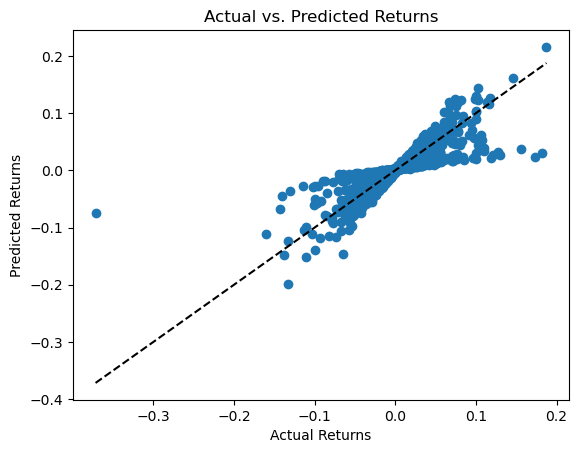

In [89]:
# Create a scatter plot of predicted vs. actual values
plt.scatter(y_linear, predicted_linear)
plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs. Predicted Returns")

# Add a diagonal line, to indicate where the points would lie if the predictions were perfect
plt.plot([y_linear.min(), y_linear.max()], [y_linear.min(), y_linear.max()], 'k--')

plt.savefig('./Images/linear_plot')

In [90]:
# Compute the metrics for the linear regression model
score = model_linear.score(X_linear, y_linear, sample_weight=None)
r2 = r2_score(y_linear, predicted_linear)
mse = mean_squared_error(y_linear, predicted_linear)
rmse = np.sqrt(mse)
std = np.std(y_linear)

## GARCH

In [91]:
# returns = sp500.loc['2008':'2009'].Close.pct_change() * 100
# returns = returns.dropna()
# returns.tail()
returns = df_ml['actual_returns']

In [92]:
from arch import arch_model
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [93]:
# Fit the GARCH Model
res = model_garch.fit(disp="off")
# Summarize the model results
res.summary()

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         actual_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2980.23
Distribution:                  Normal   AIC:                          -5954.45
Method:            Maximum Likelihood   BIC:                          -5938.41
                                        No. Observations:                 1553
Date:                Sun, Jul 09 2023   Df Residuals:                     1553
Time:                        17:55:58   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0569e-04  3.000e-05      3.523  4.263e-04 [4.690e-05,1.645e-04]
alpha[1]       0.0994  3.736e-02      2.661  7.794e-03   [2.618e-02,  0.173]
beta[1]        0.8284  3.583e-02     23.122 2.766e-118     [  0.758,  0.899]
============================================================================

Covariance estimator: robust
"""

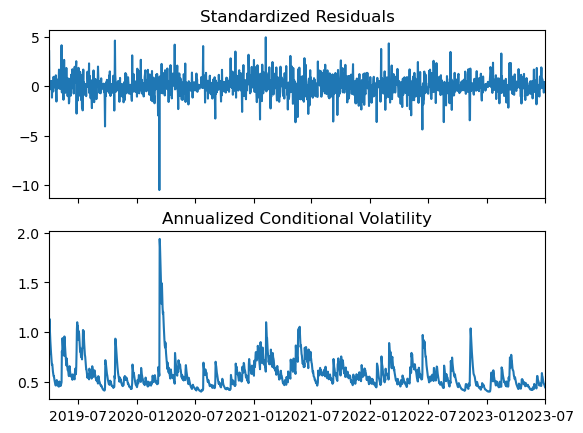

In [94]:
# Plot the model estimate of annualized volatility
fig_garch = res.plot(annualize='D')
# Save the plot
plt.savefig('./Images/garch.png')

In [95]:
# Forecasting from GARCH
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 7
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast(start='2023-07-02', horizon=forecast_horizon)
forecasts

C:\Users\boris\anaconda3\envs\dev\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [96]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate

,h.1,h.2,h.3,h.4,h.5,h.6,h.7
date,,,,,,,
2023-07-02 00:00:00+00:00,0.437951,0.452309,0.465234,0.476913,0.487498,0.497117,0.505878


In [97]:
final = intermediate.dropna().T
final

date,2023-07-02 00:00:00+00:00
h.1,0.437951
h.2,0.452309
h.3,0.465234
h.4,0.476913
h.5,0.487498
h.6,0.497117
h.7,0.505878


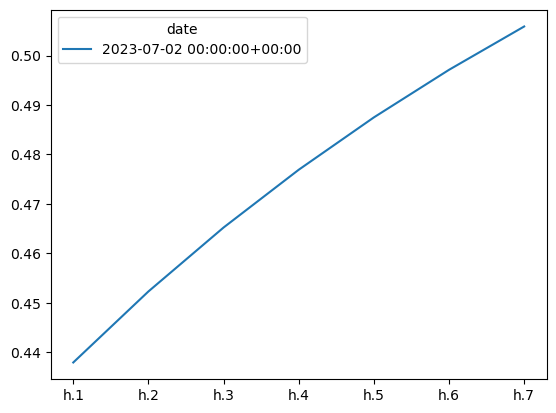

In [98]:
final_garch = final.plot()
plt.savefig('./Images/final_garch_plot.png')

# Model Reports:

## Logistic Regression Model

In [190]:
print(report_lr)
print(testing_report_lr)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       557
         1.0       0.52      1.00      0.69       607

    accuracy                           0.52      1164
   macro avg       0.26      0.50      0.34      1164
weighted avg       0.27      0.52      0.36      1164

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       200
         1.0       0.49      1.00      0.65       189

    accuracy                           0.49       389
   macro avg       0.24      0.50      0.33       389
weighted avg       0.24      0.49      0.32       389



## Linear Regression

In [ ]:
# Print releveant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

In [ ]:
img_linear = mpimg.imread('./Images/linear_plot.png')
imgplot_linear = plt.imshow(img_linear)
plt.show()

## GARCH

In [ ]:
img_garch = mpimg.imread('./Images/garch.png')
imgplot_garch = plt.imshow(img_garch)
plt.show()

In [ ]:
print(final)

In [ ]:
img_garch_final = mpimg.imread('./Images/final_garch_plot.png')
imgplot_garch_final = plt.imshow(img_garch_final)
plt.show()

## SVM

In [ ]:
print(training_report)

## Neural Network ML

In [68]:
# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.34608781337738037, Accuracy: 0.9280205368995667


## Prophet

In [70]:
print(pr_forecast_aug_2023.mean())

Best Case           33286.809778
Worst Case          25482.463712
Most Likely Case    29372.114637
dtype: float64


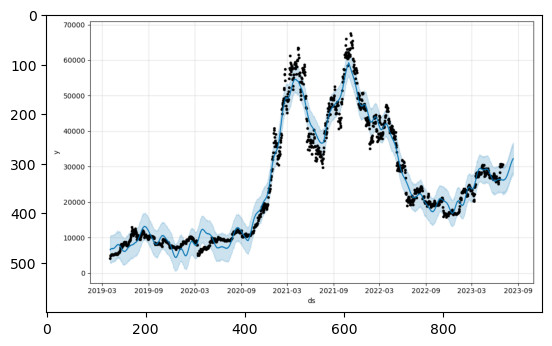

In [71]:
img_pr= mpimg.imread('./Images/prophet.png')
imgplot_pr = plt.imshow(img_pr)
plt.show()

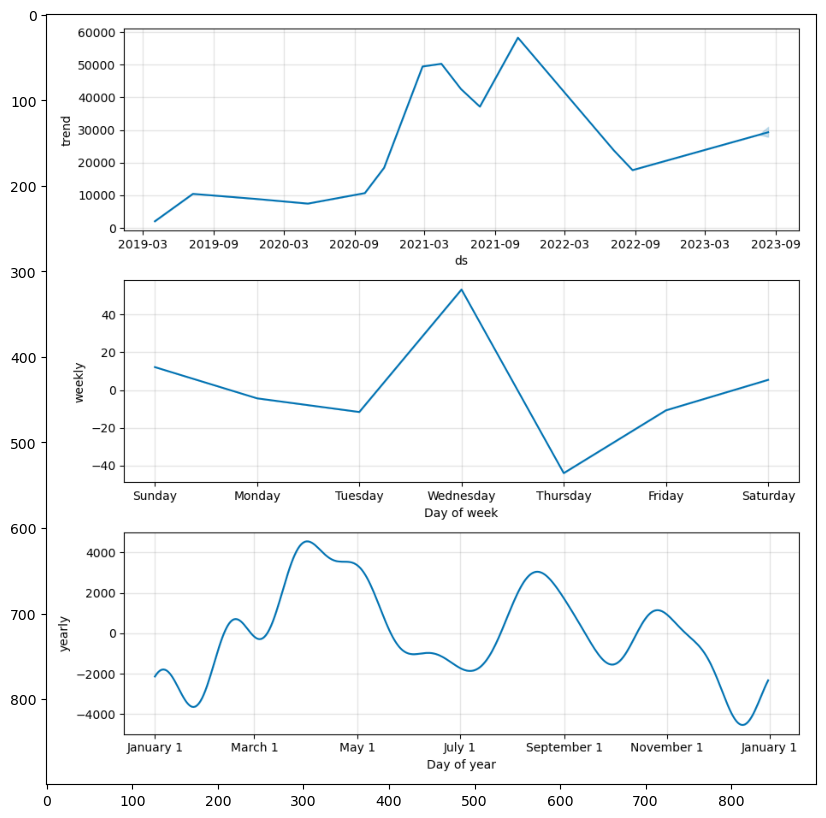

In [73]:
img_pr_com= mpimg.imread('./Images/prophet_components.png')
plt.figure(figsize=(10, 10))
imgplot_pr_com = plt.imshow(img_pr_com)
plt.show()

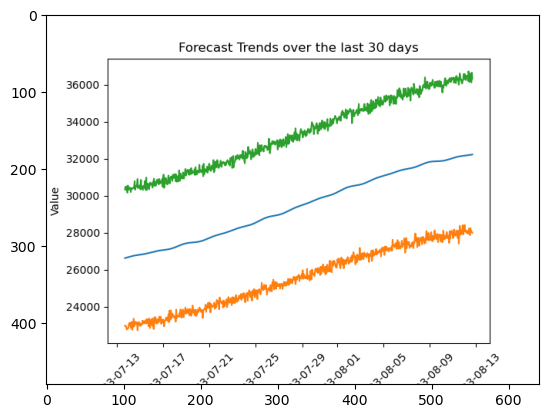

In [74]:
img_pr_predict= mpimg.imread('./Images/prophet_predict.png')
imgplot_pr_predict = plt.imshow(img_pr_predict)
plt.show()

# Save each of your alternative models as an HDF5 file

# Output
## Connect to an External Exchange (Demo Account)
or
## Send an SMS (Backup)

# Nice to have: Sentiment Analysis APIs

In [ ]:
!pip install fear_and_greed

In [ ]:
import fear_and_greed
import pandas as pd

In [ ]:
sentiment = pd.DataFrame(
    fear_and_greed.get(), 
    index=['value','description','last_update'], 
    columns=['CNN Fear & Greed Index']
)
sentiment

In [ ]:
sentiment.loc['description']

In [ ]:
sentiment.iloc[[1]]

In [ ]:
# Fear and Greed Index:
# extreme fear, fear, neutral, greed, extream greed
# < 50 : fear
# = 50 : Neutral
# > 50 : greed

In [ ]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url= 'https://paper-api.alpaca.markets',    
    api_version = "v2"
)

## Alpaca Buy/Sell Functions

In [ ]:
# Define Alpaca buy function for crypto/stocks

def buy_crypto(token,amount):
    quantity_bought = 0
    position_price = 0
    amount_paid = 0    
    buy = api.submit_order(
  symbol=token, 
  side='buy',
  notional=float(amount),
  type='market',
  time_in_force='gtc'
)
    buy_id = buy.id          
    buy_order_status = buy.status
    time.sleep(1)
    order = api.get_order(buy_id)
    print(f"Buy status: {buy.status}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".") 
    print(f"Buy id: {buy.id}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")
    print(f"Order status: {order.status}"), time.sleep(1) 
    
    if str(order.status) == 'filled':
        quantity_bought = float(order.filled_qty)
        position_price = float(order.filled_avg_price)
        amount_paid = position_price * quantity_bought
        print(f"You have sucessfully purchased ${amount} worth of {token} at ${float(position_price)} per share. Your purchased shares equate to {float(quantity_bought)}.\n")
    else:
        print("Status pending...")        
    return quantity_bought, position_price, amount_paid

In [ ]:
# Define Alpaca sell function for crypto/stocks

def sell_crypto(token):
    buy = api.submit_order(
  symbol=token, 
  side='sell',
  qty=float(quantity_bought),
  type='market',
  time_in_force='gtc'
)
    buy_id = buy.id          
    buy_order_status = buy.status  
    time.sleep(1)
    order = api.get_order(buy_id)    
    print(f"Sell status: {buy.status}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")   
    print(f"Sell id: {buy.id}", end=""), time.sleep(1), print(".", end=""), time.sleep(0.5), print(".", end=""), time.sleep(0.5), print(".")
    print(f"Order status: {order.status}"), time.sleep(1) 
    
    if str(order.status) == 'filled':
        print(f"You have sucessfully sold {float(quantity_bought)} of {token}.")
    else:
        print("Status: pending.")    

## Implement Trading Strategy

In [ ]:
# Implement trading strategy
# Dummy example buy and sell after 10 second
token = 'BTCUSD'
amount = 400

# Replace this bit with trade strategy
quantity_bought, position_price, amount_paid = buy_crypto(token, amount)
time.sleep(10)
sell_crypto(token)